# Library imports

In [1]:
import numpy as np
import math as math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
import scipy.linalg
import seaborn as sns
import time
import glob
import pandas as pd
import scipy.stats as st

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error
 
from scipy.optimize import curve_fit

from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

# Utils

In [78]:
def get_location(arr, loc):
    return np.where((arr[:,0] == loc[0])&(arr[:,1] == loc[1]))[0][0]

In [79]:
def split_df(row):
    '''
    Special distances correction
      '''
    aux = df.loc[(df['x'] == row[0]) & (df['y'] == row[1])]
    aux = aux[ap_mac].values
    aux = aux.T

    return aux

In [80]:
def mean_confidence_interval(data, confidence=0.95):
    
    """
    Clear nan values
    """
    idx = np.argwhere(np.isnan(data)).T[0]
    data = np.delete(data, idx, 0)

    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.nanmean(a), scipy.stats.sem(a, nan_policy='omit')

    """
    Check nan
    """
    if n > 1:
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    else:
        h = 0
        
    return m, (m-h), (m+h)

In [81]:
def vec_mean(vec, fac):
             
    """
    Vector length
    """
    l = int(floor(len(vec)/fac))

    """
    Vector reshaping
    """
    vec = vec[:l*fac].reshape(l,fac)

    return np.nanmean(vec, axis=1)

In [82]:
def compute_euclidean_distance(array):
    
    n = array.shape[0]

    d_mat = [np.linalg.norm(i - j) for (i,j) in itertools.product(array, array)]
    d_mat = np.array(d_mat).reshape((n, n), order='F')

    return d_mat

In [83]:
def mean_squared_error(arr, ax=0):
    return np.sqrt(np.nanmean(np.square(arr), ax))

In [84]:
def get_window_mean(obs, n):
    
    """
    Length of the observation vector
    """
    l = len(obs)

    """
    Circular saving
    """
    aux = np.insert(obs, 0, obs)

    return pd.DataFrame(aux)[0].rolling(n, min_periods=1).mean()[l:]

In [85]:
"""
Random Averaging Window

obs: input vector
s: size of the output vector
n: size of averaging samples
"""
def get_rand_avg_vec(obs,s,n):
    return np.array([np.nanmean(np.random.choice(obs, size=n)) for i in range(s)])

# Dataset Reading

In [10]:
"""
File reading
"""
df = pd.read_csv('../data/dataset_sala_actos_pixel.csv', sep = ",", index_col=False, encoding='latin-1')
df = df.replace(to_replace = -100, value = np.nan)
df.head()

,batch,x,y,z,brand,model,angle,sampleNumber,30:23:03:87:17:80#1,30:23:03:87:17:81#1,...,30:23:03:87:19:6c#1,30:23:03:87:19:6d#1,30:23:03:87:19:6e#1,36:23:03:87:17:80#1,36:23:03:87:17:98#1,36:23:03:87:19:6c#1,58:cb:52:d7:b4:d9#1,58:cb:52:d7:b5:31#1,58:cb:52:d7:b5:5d#1,58:cb:52:d7:bb:61#1
0,00ecbbfc674d9acb63628124675dca47,2.0,0.0,0.0,google,Pixel 3a,0.0,0,20.932,7.352,...,25.707,9.154,8.529,NaN,33.241,NaN,17.664,4.720,-0.504,16.417
1,00ecbbfc674d9acb63628124675dca47,2.0,0.0,0.0,google,Pixel 3a,0.0,1,19.757,7.469,...,25.620,8.669,8.602,NaN,NaN,NaN,17.976,4.183,-0.348,16.614
2,00ecbbfc674d9acb63628124675dca47,2.0,0.0,0.0,google,Pixel 3a,0.0,2,18.669,7.041,...,25.232,8.913,8.734,NaN,NaN,NaN,18.248,3.533,-0.110,16.854
3,00ecbbfc674d9acb63628124675dca47,2.0,0.0,0.0,google,Pixel 3a,0.0,3,19.770,6.913,...,NaN,9.026,8.705,NaN,NaN,NaN,17.664,3.421,-0.123,16.651
4,00ecbbfc674d9acb63628124675dca47,2.0,0.0,0.0,google,Pixel 3a,0.0,4,20.232,7.273,...,26.088,8.829,8.646,NaN,NaN,NaN,18.086,3.390,-0.191,16.692


# Radio-map definition

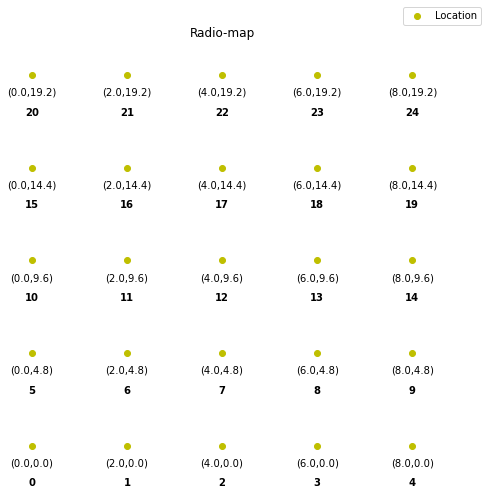

In [11]:
width =  8
height = 19.2

granularity_x = 2
granularity_y = 4.8

points_x = int(width/float(granularity_x) +1)
points_y = int(height/float(granularity_y) +1)

n_points = points_x * points_y

"""
Locations grid
"""
locations = np.array(np.meshgrid(np.linspace(0, height, points_y).round(2), np.linspace(0, width, points_x).round(2))).T.reshape(-1,2)
locations[:, [1, 0]] = locations[:, [0, 1]]

"""
Plot coordinates
"""
coordinates = np.array(np.meshgrid(np.linspace(0, points_y - 1, points_y), np.linspace(0, points_x - 1, points_x))).T.reshape(-1,2)
coordinates[:, [1, 0]] = coordinates[:, [0, 1]]

plt.figure(figsize=(points_x*1.5, points_y*1.5))

plt.scatter(coordinates[:,0], coordinates[:,1], c='y')

plt.legend(labels=['Location'],loc="upper right",borderaxespad=-5)
plt.title('Radio-map',pad=20)
plt.axis('off')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

# AP definition

## AP class

### Handles the required parameters for each AP

#### Parameters:

*   name (string)
*   x (number)
*   y (number)
*   point (number)
*   mac (string)

In [12]:
class AP:
    '''
 
    '''
    def __init__(self, _name, _x, _y, _mac):
        self.name = _name
        self.x = _x
        self.y = _y
        self.mac = _mac
        self.point = get_location(locations, [_x, _y])

## Create APs

In [13]:
"""
Selected APs for the experiment
"""

ap_list = []

ap_list.append(AP('Google White', 0, 19.2, '58:cb:52:d7:bb:61#1'))

ap_list.append(AP('Google Blue', 0, 0, '58:cb:52:d7:b5:5d#1'))

ap_list.append(AP('Google Green', 8, 0, '58:cb:52:d7:b5:31#1'))

ap_list.append(AP('Linksys 2', 0, 9.6, '30:23:03:87:17:81#1'))

ap_list.append(AP('Google Red', 8, 19.2, '58:cb:52:d7:b4:d9#1'))

#ap_list.append(AP('Linksys 3', 4, 19.2, '30:23:03:87:17:99#1'))

#ap_list.append(AP('Linksys 4', 8, 9.6, '30:23:03:87:19:6d#1'))

## AP info

In [14]:
ap_labels = {}
ap_indexes = {}
ap_mac = []

ap_info = pd.DataFrame(columns = ['Name', 'X', 'Y', 'Point', 'MAC'])

"""
Sorting AP list
"""
ap_list.sort(key=lambda x: x.point)

points = []
for (i) in range(len(ap_list)):

  points.append(ap_list[i].point)

  ap_labels[i]=ap_list[i].name
  ap_indexes[str(ap_list[i].name)]=i
  ap_mac.append(ap_list[i].mac)

  ap_info = ap_info.append(
                  {'Name': ap_list[i].name, 
                   'X': ap_list[i].x, 
                   'Y': ap_list[i].y, 
                   'Point': ap_list[i].point, 
                   'MAC': ap_list[i].mac}, ignore_index=True)

ap_info

,Name,X,Y,Point,MAC
0,Google Blue,0,0,0,58:cb:52:d7:b5:5d#1
1,Google Green,8,0,4,58:cb:52:d7:b5:31#1
2,Linksys 2,0,9.6,10,30:23:03:87:17:81#1
3,Google White,0,19.2,20,58:cb:52:d7:bb:61#1
4,Google Red,8,19.2,24,58:cb:52:d7:b4:d9#1


# Final Scenario 

In [15]:
"""
AP locations
"""
L_ap = locations[points,:]

"""
VRP locations
"""
L_vrp = np.delete(locations, points, 0)

n_ap = len(ap_list)
n_vrp = n_points - n_ap

"""
Locations split
"""
coordinates_ap = coordinates[points,:]
coordinates_vrp = np.delete(coordinates, points, 0)

## Scenario Plot

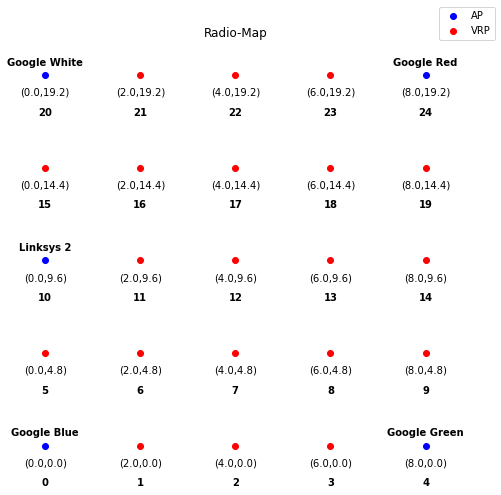

In [16]:
plt.figure(figsize=(points_x*1.5, points_y*1.5))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Radio-Map',pad=20)
plt.axis('off')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):
    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

# Dataset Processing

In [17]:
"""
Dataset split

    - L_ap --> Training locations
    - ap_obs --> RTT Distance Observations between APs
    - L_test --> Test locations
    - vrp_test --> VRP distance measurements

We are getting data from dataset, splitting AP and VRP samples

ap_tr(target AP, reference AP, sample)
vrp_test(target VRP, reference AP, sample)
"""

"""
Full dataset
"""
dataset = np.array([split_df(locations[i]) for (i) in np.linspace(0, n_points - 1, n_points).astype(int)]).round(2)

"""
Training data
"""
ap_tr = np.array([split_df(L_ap[i]) for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)]).round(2)
n_tr = ap_tr.shape[2]

"""
Locations of test data
"""
locations_test = np.array(np.meshgrid(np.linspace(0, height, 5).round(2), np.linspace(0, width, 5).round(2))).T.reshape(-1,2)
locations_test[:, [1, 0]] = locations_test[:, [0, 1]]

"""
Coordinates corresponding to test VRPs
"""
coordinates_test = np.array(np.meshgrid(np.linspace(0, 4, 5), np.linspace(0, 4, 5))).T.reshape(-1,2)
coordinates_test[:, [1, 0]] = coordinates_test[:, [0, 1]]

points_test = []
for i in range(len(ap_list)):
  points_test.append(get_location(locations_test, [ap_list[i].x, ap_list[i].y]))

coordinates_test_ap = coordinates_test[points_test,:]
coordinates_test_vrp = np.delete(coordinates_test, points_test, 0)

"""
Test locations corresponding to APs
"""
L_test = np.delete(locations_test, points_test, 0)
n_test = L_test.shape[0]

"""
Test data
"""
vrp_test = np.array([split_df(L_test[i]) for (i) in range(L_test.shape[0])]).round(2)
n_samples_test = vrp_test.shape[2]

"""
Euclidean distance computing
"""
d_euc = compute_euclidean_distance(locations_test)
d_euc_ap = d_euc[points_test,:]

# Training Data Processing

## Averaging of the training data

### Data plot

In [18]:
"""
Average random vector of observations

 - Observations vector: Training Data (ap_tr)
 - Window size: from 0 to n_factor
 - Experiment Iterations: size of the vector of ranging measurements
"""

n_factor = 50

ap_obs = np.array([np.array([np.array([np.array([get_rand_avg_vec(ap_tr[j,i,:],n_tr,l)
                                    for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                                    for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                                    for (k) in np.arange(1,n_tr+1).astype(int)])
                                    for (l) in np.arange(1,n_factor+1).astype(int)])

n_samples = ap_obs.shape[1]

/tmp/ipykernel_4086550/658129243.py:9: RuntimeWarning: Mean of empty slice
  return np.array([np.nanmean(np.random.choice(obs, size=n)) for i in range(s)])


# Polynomial Surface Fitting

In [19]:
"""
Polynomial Surface model fitting
    
    loc --> X,Y tuple array of AP locations
    d --> AP RTT distance observations
    order --> Polinomial order
"""
def surface_fit(loc, d, order=1):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(d)).T[0]
    loc = np.delete(loc, idx, 0)
    d = np.delete(d, idx)

    '''
    Computing polynomial surface coefficients
    '''
    if order == 1:
        A = np.c_[loc[:,0], loc[:,1], np.ones(loc.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    else:
        A = np.c_[np.ones(loc.shape[0]), loc[:,:2], np.prod(loc[:,:2], axis=1), loc[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    return C

In [20]:
"""
Mean RTT distance estimation
    
    x --> AP's x locations
    y --> AP's y locations
    C --> Model coefficients
"""
def sample_distance(x, y, C):
    XX = x.flatten()
    YY = y.flatten()
    
    if C.shape[0] == 3:
        fit = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(x.shape)
    else:
        fit = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(x.shape)
    return fit

## Surface Fitting Models

In [21]:
"""
Plot domain
"""
X,Y = np.meshgrid(np.linspace(0, width, points_x).round(2), np.linspace(0, height, points_y).round(2))

"""
Models fitting and surface estimation
"""

models_1 = np.empty(n_factor, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[3]
  aux = np.array([np.array([np.array([surface_fit(L_ap, obs[k,:,j,i])
                      for (i) in np.linspace(0, sp - 1, sp).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                      for (k) in np.linspace(0, n_samples -1, n_samples).astype(int)])
  models_1[k] = aux

models_2 = np.empty(n_factor, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[3]
  aux = np.array([np.array([np.array([surface_fit(L_ap, obs[k,:,j,i], 2)
                      for (i) in np.linspace(0, sp - 1, sp).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                      for (k) in np.linspace(0, n_samples -1, n_samples).astype(int)])
  models_2[k] = aux

Z_1 = np.empty(n_factor, dtype=object)
for k, coeff in enumerate(models_1):
  sp = coeff.shape[2]
  aux = np.array([np.array([np.array([sample_distance(X, Y, coeff[k,j,i,:]) 
                      for (i) in np.linspace(0, sp - 1, sp).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                      for (k) in np.linspace(0, n_samples -1, n_samples).astype(int)])
  Z_1[k] = aux

Z_2 = np.empty(n_factor, dtype=object)
for k, coeff in enumerate(models_2):
  sp = coeff.shape[2]
  aux = np.array([np.array([np.array([sample_distance(X, Y, coeff[k,j,i,:]) 
                      for (i) in np.linspace(0, sp - 1, sp).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                      for (k) in np.linspace(0, n_samples -1, n_samples).astype(int)])
  Z_2[k] = aux

## Mean RTT Distance vectors

In [22]:
"""
Mean RTT distance values at VRPs
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""

fit_1 = np.empty(n_factor, dtype=object)
for k, estimation in enumerate(Z_1):
  sp = estimation.shape[2]
  aux = np.array([np.reshape(estimation[i], (n_ap, sp, n_points, 1)) 
                  for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
  fit_1[k] = aux

fit_2 = np.empty(n_factor, dtype=object)
for k, estimation in enumerate(Z_2):
  sp = estimation.shape[2]
  aux = np.array([np.reshape(estimation[i], (n_ap, sp, n_points, 1))
                  for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
  fit_2[k] = aux

"""
Mean RTT observations between target AP and the rest
"""

m_ap_1 = np.empty(n_factor, dtype=object)
for k, fit in enumerate(fit_1):
  sp = fit.shape[2]
  aux = np.array([np.array([fit[j][:, i, points, :] for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                                      for (j) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
  m_ap_1[k] = aux

m_ap_2 = np.empty(n_factor, dtype=object)
for k, fit in enumerate(fit_2):
  sp = fit.shape[2]
  aux = np.array([np.array([fit[j][:, i, points, :] for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                                      for (j) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
  m_ap_2[k] = aux

"""
Reference points vector
"""
vrp_pts = np.delete(np.linspace(0, n_points - 1, n_points).astype(int), points, 0)

"""
Mean RTT observations between target AP and VRPs
"""

m_vrp_1 = np.empty(n_factor, dtype=object)
for k, fit in enumerate(fit_1):
  sp = fit.shape[2]
  aux = np.array([np.array([fit[j][:, i, vrp_pts, :] for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                                       for (j) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
  m_vrp_1[k] = aux

m_vrp_2 = np.empty(n_factor, dtype=object)
for k, fit in enumerate(fit_2):
  sp = fit.shape[2]
  aux = np.array([np.array([fit[j][:, i, vrp_pts, :] for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                                       for (j) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
  m_vrp_2[k] = aux

# Gaussian Process Regression

## Kernel definition

In [23]:
"""
Gaussian Process Kernel definition

Kernel parameters:
    - L --> Length Scale
    - sigma_f --> Constant Kernel Amplitude
"""

def kernel_function(x, y, sigma_f=1, l=1):

    """ Squared Exponential kernel function """
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

## Hyperparameter optimization

In [24]:
"""
Hyperparameter optimization of sigma_f and length-scale

    loc --> AP locations
    mean --> RTT distance observations between APs
"""
def gp_fit(loc, mean):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(mean)).T[0]
    loc = np.delete(loc, idx, 0)
    mean = np.delete(mean, idx)

    gp.fit(loc, mean)

    l = gp.kernel_.get_params().get('k2__length_scale')
    sigma_f = gp.kernel_.get_params().get('k1__constant_value')
    return l, sigma_f

In [25]:
"""
Gaussian Process Fit using scikit-learn GPR
"""
sigma_n = 0.5

kernel = ConstantKernel(constant_value=100.0,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=10.0, length_scale_bounds=(1e-3, 1e3))

gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10)

hyper_params = np.empty(n_factor, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[3]
  aux = np.array([np.array([np.array([gp_fit(L_ap, obs[k,:,j,i]) 
                        for (i) in np.linspace(0, sp - 1, sp).astype(int)]) 
                        for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                        for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
  hyper_params[k] = aux

## Covariance matrices

### Covariance matrix computing

In [86]:
def compute_k_matrix(loc, obs, sigma_f=1, l=1):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(obs)).T[0]
    loc = np.delete(loc, idx, 0)

    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
        - K = K(L, L)
    """
    
    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(loc, loc)]
    K = np.array(K).reshape(loc.shape[0], loc.shape[0])

    return K

In [87]:
def compute_k_star_matrix(loc, ref, obs, sigma_f=1, l=1):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(obs)).T[0]
    loc = np.delete(loc, idx, 0)

    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
        - K_star = K(L^*, L)
    """
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(ref, loc)]
    K_star = np.array(K_star).reshape(ref.shape[0], loc.shape[0])

    return K_star

In [88]:
def compute_k_star2_matrix(ref, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
        - K_star2 = K(L^*, L^*)
    """

    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(ref, ref)]
    K_star2 = np.array(K_star2).reshape(ref.shape[0], ref.shape[0])
    
    return K_star2

In [89]:
"""
Covariance matrices and regressor objects computing:

    - Covariance matrices: K, K_star, K_star2
"""

k_array = np.empty(n_factor, dtype=object)
for l, obs in enumerate(ap_obs):
    aux3 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        sp = obs.shape[3]
        aux2 = np.empty(sp, dtype=object)
        for (i) in np.linspace(0, sp - 1, sp).astype(int):
            aux = np.array([compute_k_matrix(L_ap, 
                                        obs[k,:,j,i],
                                        sigma_f=hyper_params[l][k][j,i][1], 
                                        l=hyper_params[l][k][j,i][0]) 
                            for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)], dtype=object)
            aux2[i] = aux
        aux3[k] = aux2
    k_array[l] = aux3

k_star2_array = np.empty(n_factor, dtype=object)
for l, obs in enumerate(ap_obs):
    aux3 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        sp = obs.shape[3]
        aux2 = np.empty(sp, dtype=object)
        for (i) in np.linspace(0, sp - 1, sp).astype(int):
            aux = np.array([compute_k_star2_matrix(L_vrp,
                                           sigma_f=hyper_params[l][k][j,i][1], 
                                           l=hyper_params[l][k][j,i][0]) 
                    for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)], dtype=object)
            aux2[i] = aux
        aux3[k] = aux2
    k_star2_array[l] = aux3

k_star_array = np.empty(n_factor, dtype=object)
for l, obs in enumerate(ap_obs):
    aux4 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        sp = obs.shape[3]
        aux3 = np.empty(sp, dtype=object)
        for (i) in np.linspace(0, sp - 1, sp).astype(int):
            aux2 = np.empty(n_ap, dtype=object)
            for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int):
                aux = compute_k_star_matrix(L_ap,
                                            L_vrp,
                                            obs[k,:,j,i],
                                            sigma_f=hyper_params[l][k][j,i][1], 
                                            l=hyper_params[l][k][j,i][0])
                aux2[j] = aux
            aux3[i] = aux2
        aux4[k] = aux3
    k_star_array[l] = aux4

# PSFM GPR Interpolation

## Interpolation Computing

In [90]:
def psfm_gpr_mean(m, m_star, d, K, K_star, sigma_n):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(d)).T[0]
    m = np.delete(m, idx)
    d = np.delete(d, idx)

    """Compute gaussian regression parameters."""
    s_bar_star = (m_star.reshape([m_star.shape[0], 1]) 
        + np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(K.shape[0])), d.reshape([d.shape[0], 1]) - m.reshape([m.shape[0], 1]))))
    
    return s_bar_star.reshape(n_vrp)

In [91]:
def zero_mean_gpr_mean(d, K, K_star, sigma_n):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(d)).T[0]
    d = np.delete(d, idx)

    """Compute gaussian regression parameters."""
    s_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(K.shape[0])), d.reshape([d.shape[0], 1])))
    
    return s_bar_star.reshape(n_vrp)

In [92]:
def zero_mean_gpr_cov(K, K_star2, K_star, sigma_n):

    """Compute gaussian regression parameters."""
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(K.shape[0])), K_star.T))
    
    return cov_s_star

In [93]:
"""
Zero-Mean Gaussian Process interpolations
"""
mean_array = np.empty(n_factor, dtype=object)
for l, obs in enumerate(ap_obs):
    aux2 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        sp = obs.shape[3]
        aux = np.array([np.array([zero_mean_gpr_mean(obs[k,:,j,i], 
                                                     k_array[l][k][i][j].astype(float), 
                                                     k_star_array[l][k][i][j].astype(float), 
                                                     sigma_n).reshape(n_vrp,1)
                                       for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                                       for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
        aux2[k] = aux
    mean_array[l] = aux2

var_array = np.empty(n_factor, dtype=object)
for l, obs in enumerate(ap_obs):
    aux2 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        sp = obs.shape[3]
        aux = np.array([np.array([np.diag(zero_mean_gpr_cov(k_array[l][k][i][j].astype(float), 
                                                            k_star2_array[l][k][i][j].astype(float), 
                                                            k_star_array[l][k][i][j].astype(float), 
                                                            sigma_n)).reshape(n_vrp,1)
                                        for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                                        for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
        aux2[k] = aux
    var_array[l] = aux2

"""
Order 1 PSFM Gaussian Process interpolations
"""
mean_psfm_array = np.empty(n_factor, dtype=object)
for l, obs in enumerate(ap_obs):
    aux2 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        sp = obs.shape[3]
        aux = np.array([np.array([psfm_gpr_mean(m_ap_1[l][k][i,j], 
                                                m_vrp_1[l][k][i,j], 
                                                obs[k,:,j,i], 
                                                k_array[l][k][i][j].astype(float), 
                                                k_star_array[l][k][i][j].astype(float), 
                                                sigma_n).reshape(n_vrp,1)
                                         for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                                         for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
        aux2[k] = aux
    mean_psfm_array[l] = aux2

"""
Order 2 PSFM Gaussian Process interpolations
"""
mean_psfm2_array = np.empty(n_factor, dtype=object)
for l, obs in enumerate(ap_obs):
    aux2 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        sp = obs.shape[3]
        aux = np.array([np.array([psfm_gpr_mean(m_ap_2[l][k][i,j], 
                                                m_vrp_2[l][k][i,j], 
                                                obs[k,:,j,i], 
                                                k_array[l][k][i][j].astype(float), 
                                                k_star_array[l][k][i][j].astype(float), 
                                                sigma_n).reshape(n_vrp,1)
                                         for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                                         for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
        aux2[k]=aux
    mean_psfm2_array[l] = aux2

# GPR Estimation Error

In [94]:
"""
Zero-Mean GPR vs Validation Measurements:

- Ranging System Reported RTT Distance
- Zero-Mean GPR Estimated RTT Distance

"""

zm_error_vrp = np.empty(n_factor, dtype=object)
for l, val in enumerate(mean_array):
    aux2 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        aux = np.array([np.array([np.subtract(val[k][i,:,j].flatten(),vrp_test[j,i,:])
                    for i in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                    for j in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
        aux2[k] = aux
    zm_error_vrp[l] = aux2

zm_error_ap = np.empty(n_factor, dtype=object)
for l, val in enumerate(mean_array):
    aux2 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        aux = np.array([np.array([np.subtract(val[k][i,:,j].flatten(),vrp_test[j,i,:])
                    for j in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
                    for i in np.linspace(0, n_ap - 1, n_ap).astype(int)])
        aux2[k] = aux
    zm_error_ap[l] = aux2

"""
First Order PSFM-GPR vs Validation Measurements:

- Ranging System Reported RTT Distance
- First Order PSFM-GPR Estimated RTT Distance

"""

psfm_error_vrp = np.empty(n_factor, dtype=object)
for l, val in enumerate(mean_psfm_array):
    aux2 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        aux = np.array([np.array([np.subtract(val[k][i,:,j].flatten(),vrp_test[j,i,:])
                    for i in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                    for j in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
        aux2[k] = aux
    psfm_error_vrp[l] = aux2

psfm_error_ap = np.empty(n_factor, dtype=object)
for l, val in enumerate(mean_psfm_array):
    aux2 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        aux = np.array([np.array([np.subtract(val[k][i,:,j].flatten(),vrp_test[j,i,:])
                    for j in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
                    for i in np.linspace(0, n_ap - 1, n_ap).astype(int)])
        aux2[k] = aux
    psfm_error_ap[l] = aux2

"""
Second Order PSFM-GPR vs Validation Measurements:

- Ranging System Reported RTT Distance
- Second Order PSFM-GPR Estimated RTT Distance

"""

psfm2_error_vrp = np.empty(n_factor, dtype=object)
for l, val in enumerate(mean_psfm2_array):
    aux2 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        aux = np.array([np.array([np.subtract(val[k][i,:,j].flatten(),vrp_test[j,i,:])
                    for i in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                    for j in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
        aux2[k] = aux
    psfm2_error_vrp[l] = aux2

psfm2_error_ap = np.empty(n_factor, dtype=object)
for l, val in enumerate(mean_psfm2_array):
    aux2 = np.empty(n_samples, dtype=object)
    for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int):
        aux = np.array([np.array([np.subtract(val[k][i,:,j].flatten(),vrp_test[j,i,:])
                    for j in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
                    for i in np.linspace(0, n_ap - 1, n_ap).astype(int)])
        aux2[k] = aux
    psfm2_error_ap[l] = aux2

# GPR Estimation RMSE Evolution

## Zero-Mean GPR

In [162]:
"""
RMSE Evolution
"""
rmse_evolution_zm = np.empty(n_factor,dtype=object)
for l, exp in enumerate(zm_error_ap):
    aux2 = np.empty([n_samples,n_ap])
    for k, val in enumerate(exp):
        aux = mean_squared_error(val.reshape(n_ap,n_samples*n_vrp), 1)
        aux2[k] = aux
    rmse_evolution_zm[l] = aux2

"""
Evolution Confidence Interval
"""
rmse_evo_zm_interval_ap = np.array([np.array([mean_confidence_interval(rmse_evolution_zm[j].T[i]) 
                                 for i in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                                 for j in np.linspace(0, n_factor - 1, n_factor).astype(int)])

rmse_evo_zm_interval = np.array([mean_confidence_interval(np.nanmean(rmse_evolution_zm[i],1))
                                 for i in np.linspace(0, n_factor - 1, n_factor).astype(int)])

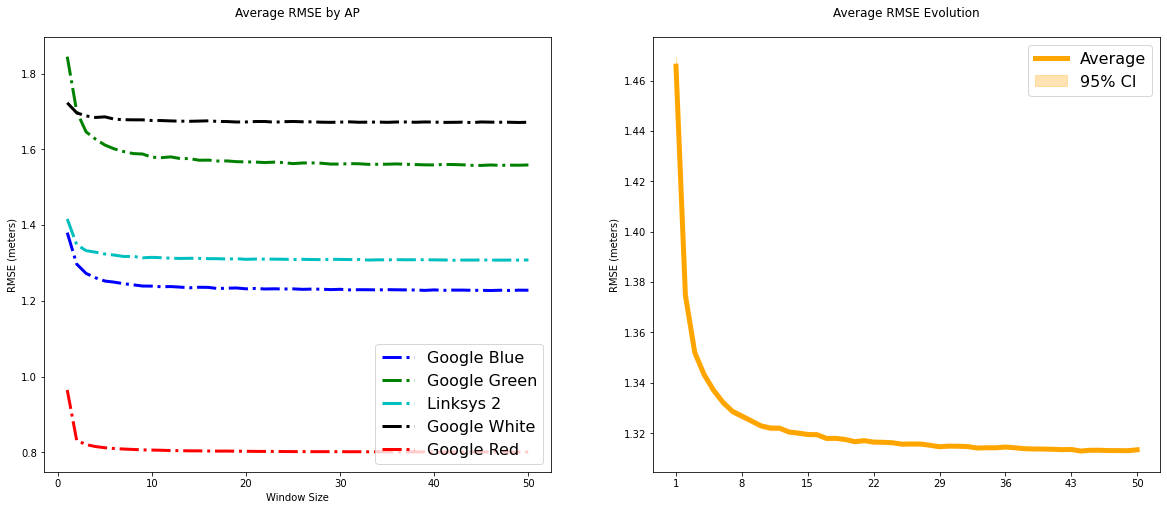

In [174]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20, 8))

ax1.set_ylabel("RMSE (meters)")
ax1.set_title("Average RMSE by AP", pad=20)

ax1.plot(np.arange(n_factor)+1,rmse_evo_zm_interval_ap.T[0,0], '-.',color='b',linewidth=3,label="Google Blue")

ax1.plot(np.arange(n_factor)+1,rmse_evo_zm_interval_ap.T[0,1], '-.',color='g',linewidth=3,label="Google Green")

ax1.plot(np.arange(n_factor)+1,rmse_evo_zm_interval_ap.T[0,2], '-.',color='c',linewidth=3,label="Linksys 2")

ax1.plot(np.arange(n_factor)+1,rmse_evo_zm_interval_ap.T[0,3], '-.',color='k',linewidth=3,label="Google White")

ax1.plot(np.arange(n_factor)+1,rmse_evo_zm_interval_ap.T[0,4], '-.',color='r',linewidth=3,label="Google Red")

ax1.set_xlabel("Window Size")

ax1.legend(loc='lower right',prop={'size':16})

ax2.set_ylabel("RMSE (meters)")
ax2.set_title("Average RMSE Evolution", pad=20)

ax2.plot(np.arange(n_factor)+1,rmse_evo_zm_interval.T[0],color='orange',linewidth=5,label="Average")

ax2.fill_between(
    np.arange(n_factor)+1,
    rmse_evo_zm_interval.T[1],
    rmse_evo_zm_interval.T[2],
    alpha=0.3,
    label=r"95% CI",
    color='orange'
)

ax2.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(0,n_factor,7)+1))
ax2.legend(loc='upper right',prop={'size':16})

plt.show()

## First Order PSFM-GPR

In [217]:
"""
RMSE Evolution
"""
rmse_evolution_psfm = np.empty(n_factor,dtype=object)
for l, exp in enumerate(psfm_error_ap):
    aux2 = np.empty([n_samples,n_ap])
    for k, val in enumerate(exp):
        aux = mean_squared_error(val.reshape(n_ap,n_samples*n_vrp), 1)
        aux2[k] = aux
    rmse_evolution_psfm[l] = aux2

"""
Evolution Confidence Interval
"""
rmse_evo_psfm_interval_ap = np.array([np.array([mean_confidence_interval(rmse_evolution_psfm[j].T[i],0.99) 
                                 for i in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                                 for j in np.linspace(0, n_factor - 1, n_factor).astype(int)])

rmse_evo_psfm_interval = np.array([mean_confidence_interval(np.nanmean(rmse_evolution_psfm[i],1),0.99)
                                 for i in np.linspace(0, n_factor - 1, n_factor).astype(int)])

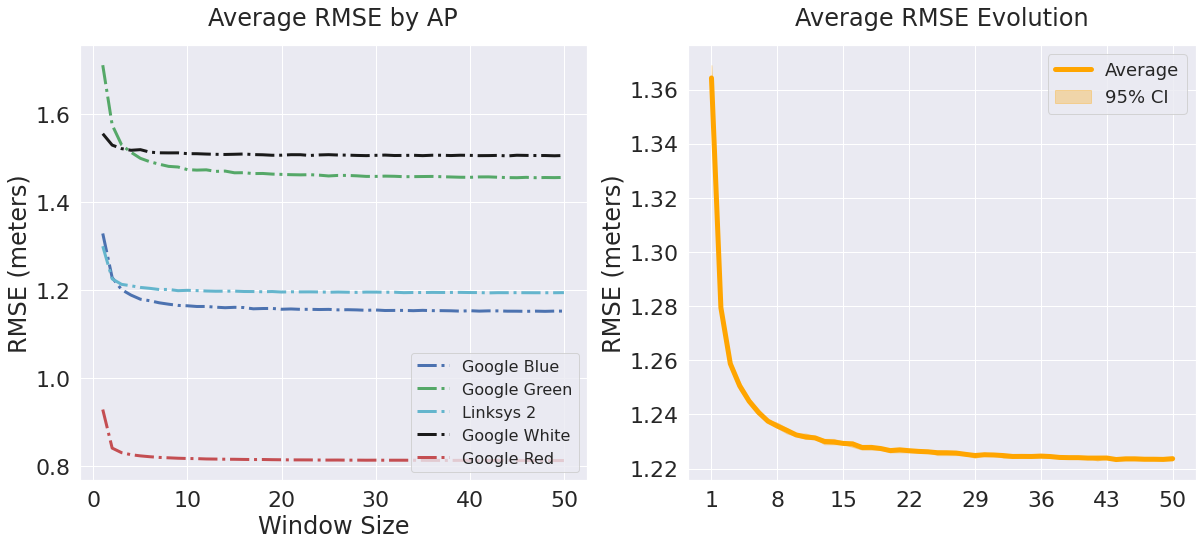

In [218]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20, 8))

ax1.set_ylabel("RMSE (meters)")
ax1.set_title("Average RMSE by AP", pad=20)

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,0], '-.',color='b',linewidth=3,label="Google Blue")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,1], '-.',color='g',linewidth=3,label="Google Green")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,2], '-.',color='c',linewidth=3,label="Linksys 2")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,3], '-.',color='k',linewidth=3,label="Google White")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,4], '-.',color='r',linewidth=3,label="Google Red")

ax1.set_xlabel("Window Size")

ax1.legend(loc='lower right',prop={'size':16})

ax2.set_ylabel("RMSE (meters)")
ax2.set_title("Average RMSE Evolution", pad=20)

ax2.plot(np.arange(50)+1,rmse_evo_psfm_interval.T[0],color='orange',linewidth=5,label="Average")

ax2.fill_between(
    np.arange(50)+1,
    rmse_evo_psfm_interval.T[1].round(3),
    rmse_evo_psfm_interval.T[2].round(3),
    alpha=0.3,
    label=r"95% CI",
    color='orange'
)

ax2.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(0,n_factor,7)+1))
ax2.legend(loc='upper right',prop={'size':18})

plt.rc('font', size=20)
plt.show()

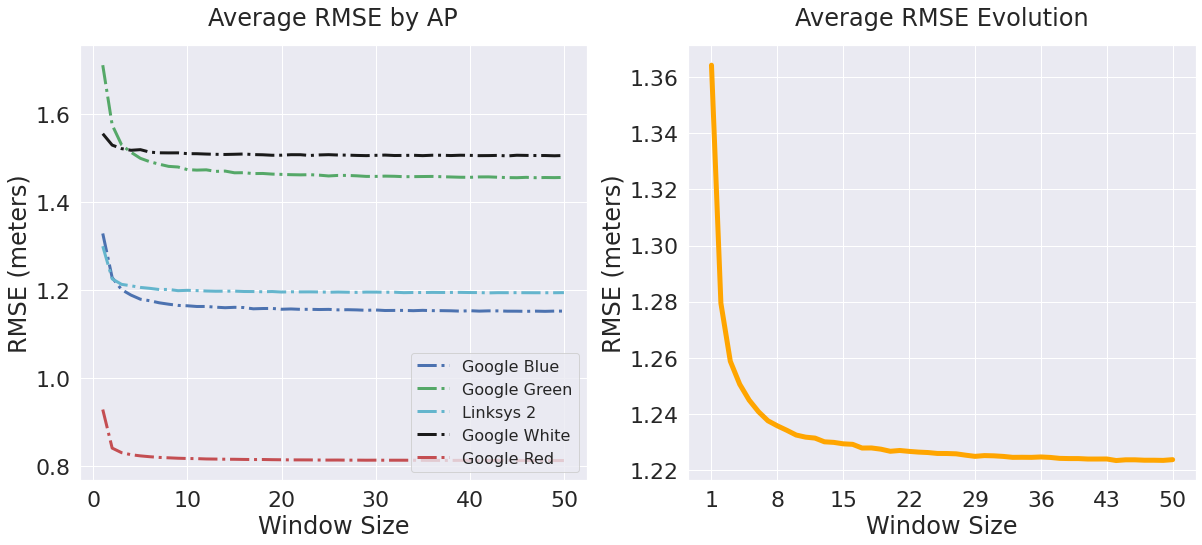

In [232]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20, 8))

ax1.set_ylabel("RMSE (meters)")
ax1.set_title("Average RMSE by AP", pad=20)

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,0], '-.',color='b',linewidth=3,label="Google Blue")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,1], '-.',color='g',linewidth=3,label="Google Green")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,2], '-.',color='c',linewidth=3,label="Linksys 2")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,3], '-.',color='k',linewidth=3,label="Google White")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,4], '-.',color='r',linewidth=3,label="Google Red")

ax1.set_xlabel("Window Size")

ax1.legend(loc='lower right',prop={'size':16})

ax2.set_ylabel("RMSE (meters)")
ax2.set_title("Average RMSE Evolution", pad=20)

ax2.plot(np.arange(50)+1,rmse_evo_psfm_interval.T[0],color='orange',linewidth=5,label="Average")

ax2.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(0,n_factor,7)+1))

sns.set(font_scale=2)

ax2.set_xlabel("Window Size")
               
plt.show()

In [220]:
"""
Export results to CSV
"""

"""
Average RMSE by AP
"""

d = {
    'Google Blue': rmse_evo_psfm_interval_ap.T[0,0],
    'Google Green': rmse_evo_psfm_interval_ap.T[0,1],
    'Linksys 2': rmse_evo_psfm_interval_ap.T[0,2],
    'Google White': rmse_evo_psfm_interval_ap.T[0,3],
    'Google Red': rmse_evo_psfm_interval_ap.T[0,4]
}

data = pd.DataFrame(d)
data.to_csv("average_rmse_by_ap.csv", index=False, header=False)
data.head()

,Google Blue,Google Green,Linksys 2,Google White,Google Red
0,1.328237,1.710972,1.299285,1.555104,0.927779
1,1.227847,1.575055,1.224934,1.529234,0.840092
2,1.200544,1.529827,1.212541,1.521206,0.829702
3,1.188090,1.512935,1.209226,1.517439,0.825076
4,1.178676,1.499136,1.205539,1.518869,0.822390


In [221]:
"""
Export results to CSV
"""

"""
RMSE Evolution
"""

d = {
    'Min': rmse_evo_psfm_interval.T[1],
    'Avg': rmse_evo_psfm_interval.T[0],
    'Max': rmse_evo_psfm_interval.T[2]
}

data = pd.DataFrame(d)
data.to_csv("average_rmse_evolution.csv", index=False, header=False)
data.head()

,Min,Avg,Max
0,1.359277,1.364276,1.369274
1,1.277452,1.279432,1.281412
2,1.257332,1.258764,1.260196
3,1.249290,1.250553,1.251816
4,1.243743,1.244922,1.246101


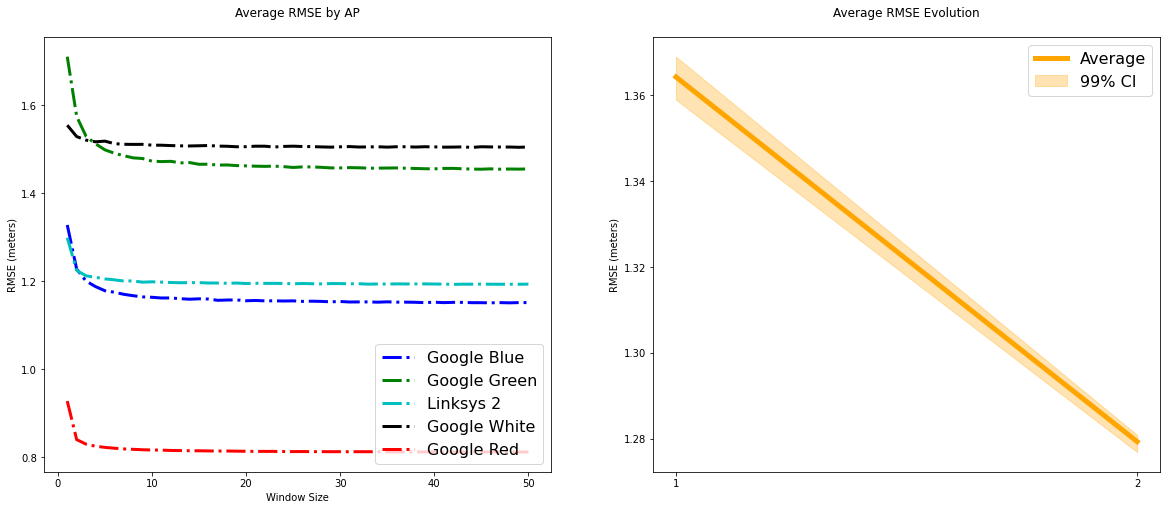

In [206]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20, 8))

ax1.set_ylabel("RMSE (meters)")
ax1.set_title("Average RMSE by AP", pad=20)

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,0], '-.',color='b',linewidth=3,label="Google Blue")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,1], '-.',color='g',linewidth=3,label="Google Green")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,2], '-.',color='c',linewidth=3,label="Linksys 2")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,3], '-.',color='k',linewidth=3,label="Google White")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm_interval_ap.T[0,4], '-.',color='r',linewidth=3,label="Google Red")

ax1.set_xlabel("Window Size")

ax1.legend(loc='lower right',prop={'size':16})

ax2.set_ylabel("RMSE (meters)")
ax2.set_title("Average RMSE Evolution", pad=20)

ax2.plot(np.arange(2)+1,rmse_evo_psfm_interval.T[0,[0,1]],color='orange',linewidth=5,label="Average")

ax2.fill_between(
    np.arange(2)+1,
    rmse_evo_psfm_interval.T[1,[0,1]].round(3),
    rmse_evo_psfm_interval.T[2,[0,1]].round(3),
    alpha=0.3,
    label=r"99% CI",
    color='orange'
)

ax2.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([1,2]))
ax2.legend(loc='upper right',prop={'size':16})

plt.show()

## Second Order PSFM-GPR RMSE Evolution

In [207]:
"""
RMSE Evolution
"""
rmse_evolution_psfm2 = np.empty(n_factor,dtype=object)
for l, exp in enumerate(psfm2_error_ap):
    aux2 = np.empty([n_samples,n_ap])
    for k, val in enumerate(exp):
        aux = mean_squared_error(val.reshape(n_ap,n_samples*n_vrp), 1)
        aux2[k] = aux
    rmse_evolution_psfm2[l] = aux2

"""
Evolution Confidence Interval
"""
rmse_evo_psfm2_interval_ap = np.array([np.array([mean_confidence_interval(rmse_evolution_psfm2[j].T[i]) 
                                 for i in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                                 for j in np.linspace(0, n_factor - 1, n_factor).astype(int)])

rmse_evo_psfm2_interval = np.array([mean_confidence_interval(np.nanmean(rmse_evolution_psfm2[i],1))
                                 for i in np.linspace(0, n_factor - 1, n_factor).astype(int)])

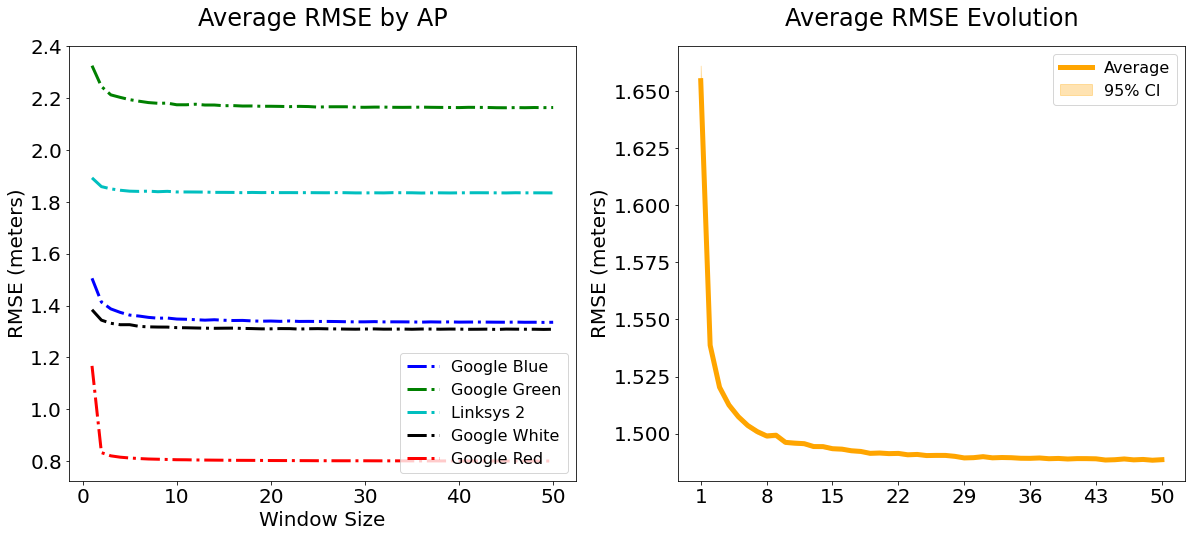

In [213]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20, 8))

ax1.set_ylabel("RMSE (meters)")
ax1.set_title("Average RMSE by AP", pad=20)

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm2_interval_ap.T[0,0], '-.',color='b',linewidth=3,label="Google Blue")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm2_interval_ap.T[0,1], '-.',color='g',linewidth=3,label="Google Green")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm2_interval_ap.T[0,2], '-.',color='c',linewidth=3,label="Linksys 2")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm2_interval_ap.T[0,3], '-.',color='k',linewidth=3,label="Google White")

ax1.plot(np.arange(n_factor)+1,rmse_evo_psfm2_interval_ap.T[0,4], '-.',color='r',linewidth=3,label="Google Red")

ax1.set_xlabel("Window Size")

ax1.legend(loc='lower right',prop={'size':16})

ax2.set_ylabel("RMSE (meters)")
ax2.set_title("Average RMSE Evolution", pad=20)

ax2.plot(np.arange(n_factor)+1,rmse_evo_psfm2_interval.T[0],color='orange',linewidth=5,label="Average")

ax2.fill_between(
    np.arange(n_factor)+1,
    rmse_evo_psfm2_interval.T[1],
    rmse_evo_psfm2_interval.T[2],
    alpha=0.3,
    label=r"95% CI",
    color='orange'
)

ax2.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(0,n_factor,7)+1))
ax2.legend(loc='upper right',prop={'size':16})

plt.show()